In [ ]:
!pip install --upgrade datasets fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

In [ ]:
from google.colab import drive
#!pip install transformers datasets accelerate


drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, Trainer
import torch
from datasets import load_dataset, Dataset
from google.colab import drive
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import os
from transformers import AutoModelForCausalLM
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model


dataset = load_dataset("isaacrehg/poetry-instructions", verification_mode="no_checks")

README.md:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

(…)-00000-of-00001-f9026b3e4b9aab48.parquet:   0%|          | 0.00/80.9M [00:00<?, ?B/s]

(…)-00000-of-00001-8b9ddb74a3fd048e.parquet:   0%|          | 0.00/5.08M [00:00<?, ?B/s]

(…)-00000-of-00001-1c0e7b1de7a62c6e.parquet:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1322 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/111 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/331 [00:00<?, ? examples/s]

In [ ]:
print(dataset)
print(dataset['train'][0])

DatasetDict({
    train: Dataset({
        features: ['conversation'],
        num_rows: 1764
    })
    validation: Dataset({
        features: ['conversation'],
        num_rows: 111
    })
    test: Dataset({
        features: ['conversation'],
        num_rows: 331
    })
})
{'conversation': "User: Can you write me a poem about faults and love?\nAssistant: Sure, here's a poem about faults and love:\n  They came to tell your faults to me,\nThey named them over one by one;\nI laughed aloud when they were done,\nI knew them all so well before, \nOh, they were blind, too blind to see\nYour faults had made me love you more."}


In [ ]:
# Define parsing function
def parse_example(example):
    convo = example["conversation"]

    # Split on 'Assistant:'
    if "Assistant:" in convo:
        user_part, assistant_part = convo.split("Assistant:", 1)

        # Clean User: part
        prompt = user_part.replace("User:", "").strip()

        # Clean Assistant: part
        completion = assistant_part.strip()

    else:
        # If no Assistant:, fallback
        prompt = convo
        completion = ""

    return {
        "prompt": prompt,
        "completion": completion
    }

# Apply to all splits
dataset["train"] = dataset["train"].map(parse_example)
dataset["validation"] = dataset["validation"].map(parse_example)
dataset["test"] = dataset["test"].map(parse_example)

# Remove 'conversation' column
dataset["train"] = dataset["train"].remove_columns(['conversation'])
dataset["validation"] = dataset["validation"].remove_columns(['conversation'])
dataset["test"] = dataset["test"].remove_columns(['conversation'])

# Check result
print(dataset["train"])
print(dataset["train"].column_names)
print(dataset["train"][0])



Map:   0%|          | 0/1764 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/331 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'completion'],
    num_rows: 1764
})
['prompt', 'completion']
{'prompt': 'Can you write me a poem about faults and love?', 'completion': "Sure, here's a poem about faults and love:\n  They came to tell your faults to me,\nThey named them over one by one;\nI laughed aloud when they were done,\nI knew them all so well before, \nOh, they were blind, too blind to see\nYour faults had made me love you more."}


In [ ]:
path = '/content/drive/Shareddrives/DeepLearning/UPF_Deep_Learning_2025/Project/Codi'

model = AutoModelForCausalLM.from_pretrained(os.path.join(path, "PFP_241_funciona_gpt2"))
tokenizer = AutoTokenizer.from_pretrained(os.path.join(path, "PFP_241_funciona_gpt2"))

In [ ]:
# Define tokenization function
def tokenize(example):
    # List comprehension: for each example in batch
    texts = [
        p + " " + c
        for p, c in zip(example["prompt"], example["completion"])
    ]

    # Tokenize the batch of texts
    encodings = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=512
    )

    return {
        "input_ids": encodings["input_ids"],
        "attention_mask": encodings["attention_mask"],
        "labels": encodings["input_ids"]  # causal LM: labels = input_ids
    }


# Apply to each split

tokenized_train = dataset["train"].map(
    tokenize,
    batched=True,
    remove_columns=["prompt", "completion"]
)

tokenized_val = dataset["validation"].map(
    tokenize,
    batched=True,
    remove_columns=["prompt", "completion"]
)

tokenized_test = dataset["test"].map(
    tokenize,
    batched=True,
    remove_columns=["prompt", "completion"]
)




Map:   0%|          | 0/1764 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/331 [00:00<?, ? examples/s]

In [ ]:
# Check result
print(tokenized_train)
print(tokenized_train.column_names)
print(tokenized_train[0])

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1764
})
['input_ids', 'attention_mask', 'labels']
{'input_ids': [6090, 345, 3551, 502, 257, 21247, 546, 31025, 290, 1842, 30, 10889, 11, 994, 338, 257, 21247, 546, 31025, 290, 1842, 25, 198, 220, 1119, 1625, 284, 1560, 534, 31025, 284, 502, 11, 198, 2990, 3706, 606, 625, 530, 416, 530, 26, 198, 40, 13818, 32227, 618, 484, 547, 1760, 11, 198, 40, 2993, 606, 477, 523, 880, 878, 11, 220, 198, 5812, 11, 484, 547, 7770, 11, 1165, 7770, 284, 766, 198, 7120, 31025, 550, 925, 502, 1842, 345, 517, 13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 5

In [ ]:
training_args = TrainingArguments(
    output_dir=os.path.join(path, "funciona_gpt2_f"),
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=10,
    learning_rate=1e-4,
    fp16=True,
    save_strategy="epoch",
    logging_steps=10,
    report_to="none"
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val
)

trainer.train()
eval_results = trainer.evaluate()
print(f"Validation results: {eval_results}")
test_results = trainer.evaluate(tokenized_test)
print(f"Test results: {test_results}")

<ipython-input-12-540715bc45fe>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
10,3.702800
20,3.220500
30,3.453200
40,3.139800
50,3.524300
60,3.174600
70,3.201400
80,3.100100
90,3.077100
100,2.908100


Validation results: {'eval_loss': 2.1677463054656982, 'eval_runtime': 2.4248, 'eval_samples_per_second': 45.777, 'eval_steps_per_second': 5.774, 'epoch': 10.0}
Test results: {'eval_loss': 2.160578727722168, 'eval_runtime': 6.5821, 'eval_samples_per_second': 50.288, 'eval_steps_per_second': 6.381, 'epoch': 10.0}


In [ ]:
model.eval()
prompt = "The sea is blue, the sky is red"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
output = model.generate(
    **inputs,
    max_new_tokens=250,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The sea is blue, the sky is red;
And I hear a great bird that says 'Go' and flies away.

  The sun comes down on his golden bars: he fills them with song!


In [ ]:
prompt = "Write a poem about the sea and the sky"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
output = model.generate(
    **inputs,
    max_new_tokens=250,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Write a poem about the sea and the sky? Sure, here's a poem about you:
  The Sea-Sea Wind that blows on me is like one whose breath has been blown;


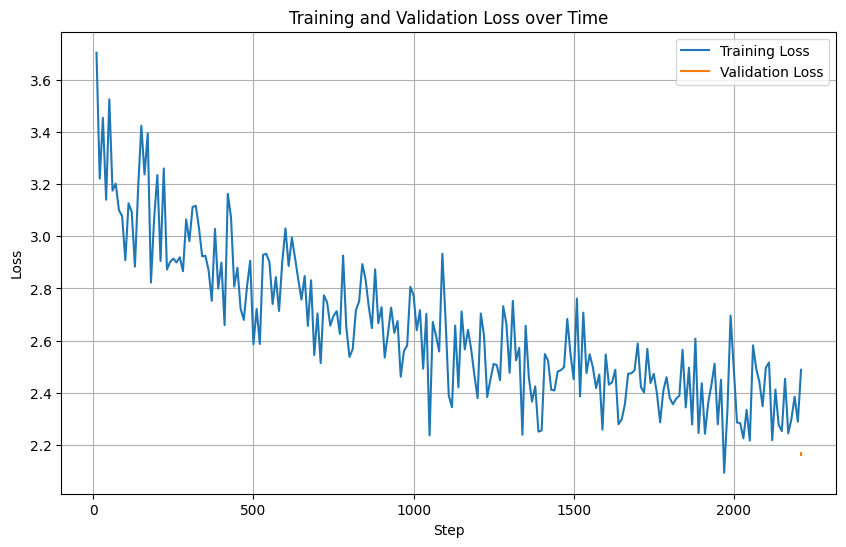

In [ ]:
import matplotlib.pyplot as plt

# Extract log history
logs = trainer.state.log_history

# Get training and eval losses
train_steps = [log["step"] for log in logs if "loss" in log]
train_loss = [log["loss"] for log in logs if "loss" in log]

eval_steps = [log["step"] for log in logs if "eval_loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss, label="Training Loss")
plt.plot(eval_steps, eval_loss, label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.title("Training and Validation Loss over Time")
plt.show()
